<a href="https://colab.research.google.com/github/petersenmatthew/ai-skill-showcase/blob/feature%2Fmatthew/matthew_showcase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Matthew Petersen


---

Hey there! My name is Matthew Petersen and I am a 1A Systems Deisgn Engineering student!

In [163]:
# import libs
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from google.colab import files
import zipfile
import kagglehub as kh
# pytorch libs
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F

In [164]:
# download dataset from kaggle
dataset_path = kh.dataset_download("mdkabinhasan/sports-ball-dataset")

# dataset root w/ class folders
dataset_root = os.path.join(dataset_path, "Sports-Ball-Dataset")

Using Colab cache for faster access to the 'sports-ball-dataset' dataset.


In [165]:
# check if GPU is available

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [166]:
data_path = os.path.join(path, "Sports-Ball-Dataset")

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Full dataset
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Train/test split (80/20)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_data, test_data = random_split(full_dataset, [train_size, test_size])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}, Test batches: {len(test_loader)}")


Train batches: 67, Test batches: 17


In [167]:
# cnn design

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # first convolutional layer - 3 input channels (RGB), 16 output channels
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # reduces spatial dimensions by a factor of 2
        # second convolutional layer - 16 input channels from previous layer, 32 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # fully connected layer 1 - input features = 32*32*32
        self.fc2 = nn.Linear(128, num_classes)   # fully connected layer 2 - output = number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=len(full_dataset.classes))
model = model.to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=32768, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [168]:
# define loss range and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [173]:
num_epochs = 8  # can be changed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/8], Loss: 2.1055
Epoch [2/8], Loss: 1.7459
Epoch [3/8], Loss: 1.4736
Epoch [4/8], Loss: 1.1903
Epoch [5/8], Loss: 0.8602
Epoch [6/8], Loss: 0.5674
Epoch [7/8], Loss: 0.3607
Epoch [8/8], Loss: 0.2452


In [174]:
model.eval()  # evaluation mode
correct = 0
total = 0

with torch.no_grad():  # no gradients in testing
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 45.61%


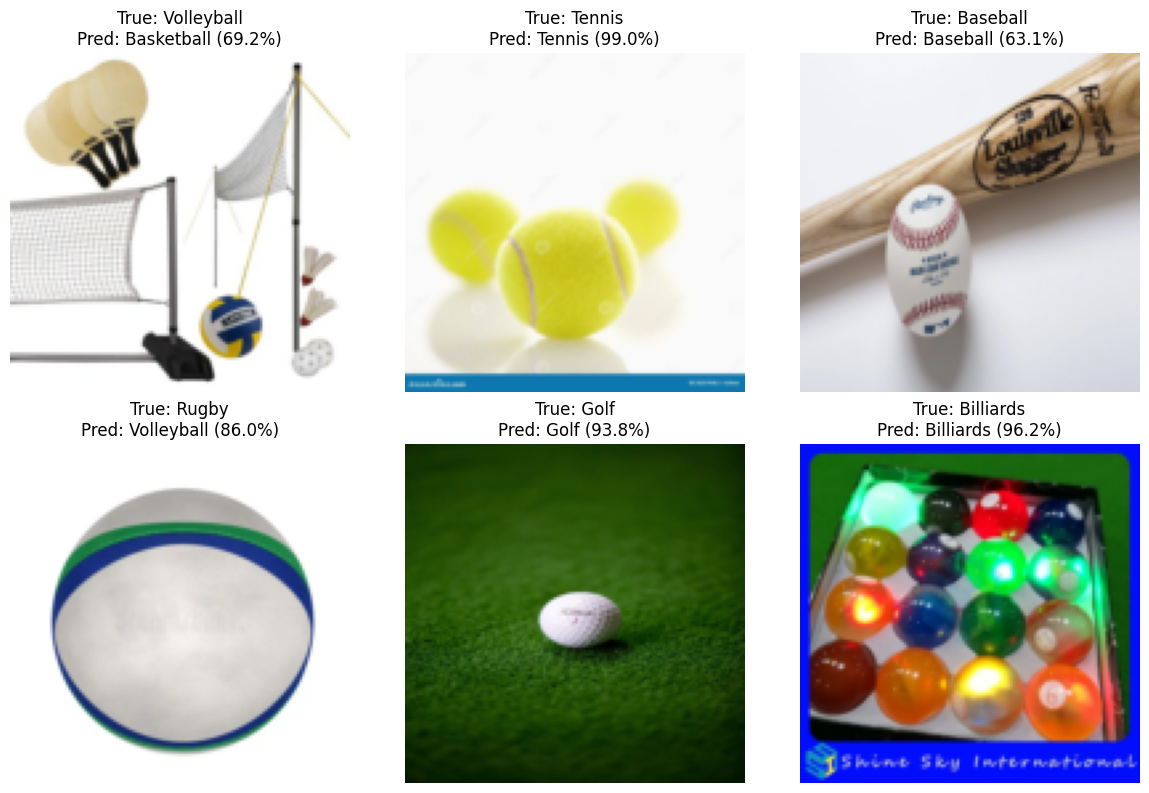

In [179]:
import random
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Pick 6 random indices from the test dataset
num_images = 6
indices = random.sample(range(len(test_data)), num_images)

# Grab the images and labels
images = torch.stack([test_data[i][0] for i in indices]).to(device)
labels = torch.tensor([test_data[i][1] for i in indices]).to(device)

# Get model predictions and probabilities
model.eval()
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities
    _, preds = torch.max(outputs, 1)

# Plot images with true labels, predicted labels, and confidence
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0)  # Convert from (C,H,W) to (H,W,C)
    ax.imshow(img)

    true_label = full_dataset.classes[labels[i]]  # True label
    pred_label = full_dataset.classes[preds[i]]  # Predicted label
    confidence = probs[i][preds[i]].item() * 100       # Confidence percentage

    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({confidence:.1f}%)")
    ax.axis("off")

plt.tight_layout()
plt.show()